In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [353]:
milk = pd.read_csv('Monthly2.csv',index_col='Month')

In [354]:
milk.shape

(168, 1)

In [355]:
milk.index = pd.to_datetime(milk.index)

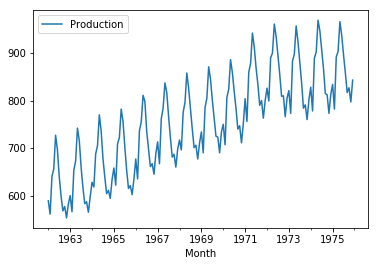

In [356]:
milk.plot()

In [357]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Production    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


In [358]:
train_set = milk.head(156)

In [359]:
test_set = milk.tail(12)

In [360]:
from sklearn.preprocessing import MinMaxScaler

In [361]:
scaler = MinMaxScaler()

In [362]:
train_scaled = scaler.fit_transform(train_set)

C:\Users\jaish\Anaconda3\envs\RNN\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [363]:
test_scaled = scaler.transform(test_set)

### Creating a Batch Function

In [364]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data,batch
    """
    rand_start = np.random.randint(0,len(training_data)-steps)
    
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    
    return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1)

### Setup the RNN Model

In [365]:
import tensorflow as tf
tf.reset_default_graph()

##### Defining Constants

In [366]:
num_inputs = 1

num_time_steps = 12

num_neurons = 100

num_outputs = 1

learning_rate = 0.01

num_train_interations = 8000

batch_size = 1

#### Create PlaceHolders

In [367]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])


In [368]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons,activation=tf.nn.relu)
        ,output_size=num_outputs)

##### Pass in the cell variables and the input placeholder(X)

In [369]:
outputs , state =tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

##### Create the Loss Function and Optimizer

In [370]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [371]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

##### Init Global Variable

In [372]:
init = tf.global_variables_initializer()

#### Create instance of tf.train.Saver()

In [373]:
saver = tf.train.Saver()

#### Running Session 

##### To avoid no memory error allocate GPU memory for faster computation.

In [374]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [375]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(init)
                
    for iteration in range(num_train_interations):
                
        X_batch , y_batch = next_batch(train_scaled,batch_size,num_time_steps)
            
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
                
        if iteration%100 == 0:
                
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE",mse)
            
    # this saves the model and can be reloaded when needed later
    saver.save(sess,"./time_series_model")

0 	MSE 0.2784891
100 	MSE 0.010609181
200 	MSE 0.011861562
300 	MSE 0.008524493
400 	MSE 0.008238639
500 	MSE 0.009669703
600 	MSE 0.009787002
700 	MSE 0.0028293922
800 	MSE 0.0071127224
900 	MSE 0.013568766
1000 	MSE 0.0075870515
1100 	MSE 0.004615215
1200 	MSE 0.003759101
1300 	MSE 0.0071395095
1400 	MSE 0.013480637
1500 	MSE 0.0062514693
1600 	MSE 0.00560552
1700 	MSE 0.0051499456
1800 	MSE 0.009472926
1900 	MSE 0.005673791
2000 	MSE 0.0070021264
2100 	MSE 0.00668055
2200 	MSE 0.001521023
2300 	MSE 0.00372519
2400 	MSE 0.00493951
2500 	MSE 0.0051772315
2600 	MSE 0.00280777
2700 	MSE 0.0035240252
2800 	MSE 0.004318727
2900 	MSE 0.00715816
3000 	MSE 0.004490137
3100 	MSE 0.0036678333
3200 	MSE 0.0037233355
3300 	MSE 0.003026315
3400 	MSE 0.0037955774
3500 	MSE 0.002329497
3600 	MSE 0.003317895
3700 	MSE 0.0013636855
3800 	MSE 0.0008093384
3900 	MSE 0.004686343
4000 	MSE 0.00088644604
4100 	MSE 0.0027745655
4200 	MSE 0.0018332644
4300 	MSE 0.007432141
4400 	MSE 0.0055108983
4500 	MSE 0

##### Predictions for Last 12 Months

In [376]:
test_set

,Production
Month,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817


In [377]:
with tf.Session() as sess:
     
    saver.restore(sess,"./time_series_model")
    
    train_seed = list(train_scaled[-12:])
    
    for iteration in range(12):
        
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        train_seed.append(y_pred[0,-1,0])
        
        
                          

INFO:tensorflow:Restoring parameters from ./time_series_model


In [378]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.61659974,
 0.59072614,
 0.7798037,
 0.79293436,
 0.8828424,
 0.80032057,
 0.7028869,
 0.61394775,
 0.5283245,
 0.5226666,
 0.4726818,
 0.54695916]

In [379]:
result = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [380]:
test_set['Generated']=result

C:\Users\jaish\Anaconda3\envs\RNN\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [381]:
test_set

,Production,Generated
Month,,
1975-01-01,834,809.505493
1975-02-01,782,798.742065
1975-03-01,892,877.398315
1975-04-01,903,882.860718
1975-05-01,966,920.262451
1975-06-01,937,885.933350
1975-07-01,896,845.400879
1975-08-01,858,808.402222
1975-09-01,817,772.782959


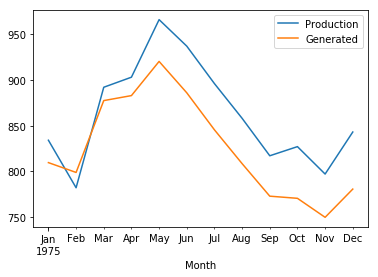

In [382]:
test_set.plot()